In [138]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

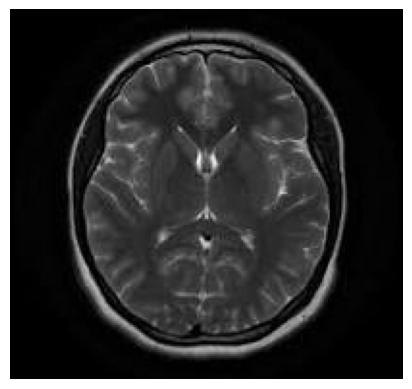

In [139]:
img = cv2.imread('images/Brain_MRI.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
brain_mri = img.copy()
plt.axis('off')
plt.imshow(img, cmap='gray')

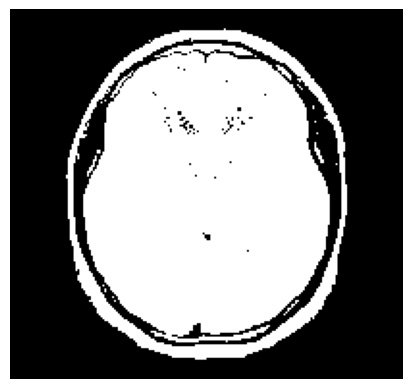

In [140]:
t = img.mean()
binary_mask = img > t
plt.axis('off')
plt.imshow(binary_mask, cmap='gray')

In [141]:
# Eliminate skull recursively 
def label_shull(x, y):
    if(binary_mask[x, y] == 0):
        return
    else:
        binary_mask[x, y] = 0
        label_shull(x+1, y)
        label_shull(x-1, y)
        label_shull(x, y+1)
        label_shull(x, y-1)

In [142]:
# Find some pixel of the skull so that after that we can eliminate the whole skull by using label_shull function
x = int(binary_mask.shape[0]/2)
y = 1
while(not(binary_mask[x,y-1] and binary_mask[x,y+1] and binary_mask[x-1,y] and binary_mask[x+1,y])):
    y += 1

In [143]:
label_shull(x, y)

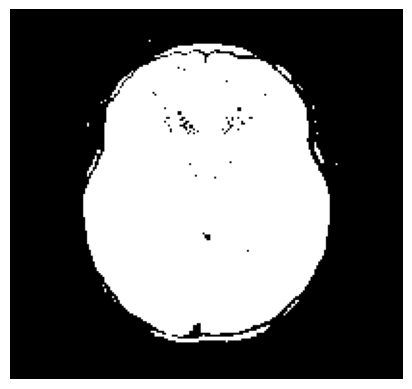

In [144]:
plt.axis('off')
plt.imshow(binary_mask, cmap='gray')

In [145]:
# purify the binary image
for i in range(1,binary_mask.shape[0]-1):
    for j in range(1,binary_mask.shape[1]-1):
        if(binary_mask[i-1,j] + binary_mask[i+1,j] + binary_mask[i,j-1] + binary_mask[i,j+1] < 1):
            binary_mask[i,j] = 0

In [146]:
# extracting the braing from the original image using our binary mask
masked_image = brain_mri.copy()
for i in range(binary_mask.shape[0]):
    for j in range(binary_mask.shape[1]):
        if(binary_mask[i,j] == 0):
            masked_image[i,j] = 0

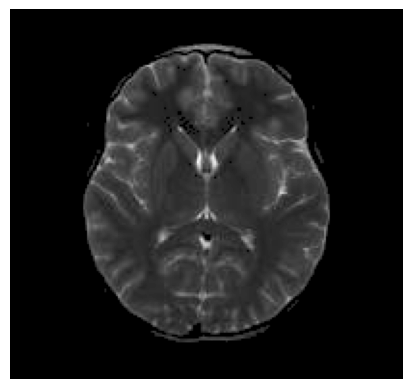

In [147]:
plt.axis('off')
plt.imshow(masked_image, cmap='gray')

In [148]:
# collecting data from the brain image
pix_vals = []
for i in range(masked_image.shape[0]):
    for j in range(masked_image.shape[1]):
        if(masked_image[i,j] > 0):
            pix_vals.append(masked_image[i,j])

In [149]:
# helper functions from the previous notebook
#K-means ++ initialization
def kmeans_plus_plus_initialization(pix_vals, k):
    centroids = []
    centroids.append(pix_vals[np.random.randint(pix_vals.shape[0])])
    for _ in range(1, k):
        dist = np.array([min([(np.subtract(c,x))**2 for c in centroids]) for x in pix_vals])
        probs = dist/dist.sum()
        cumulative_probs = probs.cumsum()   
        r = np.random.rand()
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        centroids.append(pix_vals[i])
    return np.array(centroids)

#distance function
def V(v1, v2):
    if(v1 > v2):
        return (v1 - v2)
    else:
        return (v2 - v1)

#E step
#Assign clusters to each pixel
def assign_clusters(pix_vals, centroids):
    clusters = np.zeros(len(pix_vals))
    for i, pix in enumerate(pix_vals):
        distances = [V(pix, centroid) for centroid in centroids]
        clusters[i] = np.argmin(distances)
    return clusters

#M step
#Update centroids based on the assigned clusters
def update_centroids(pix_vals, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster = pix_vals[clusters == i]
        new_centroids.append(np.mean(cluster, axis=0))
    return np.array(new_centroids)

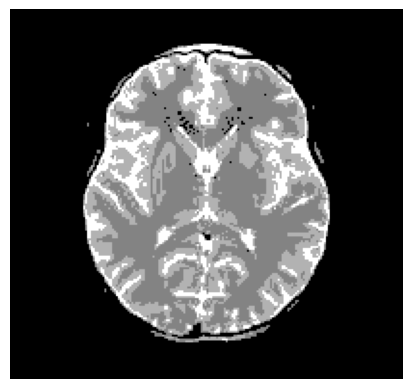

In [150]:
# k-means clustering, k = 3
k = 3

centroids = kmeans_plus_plus_initialization(np.array(pix_vals), k)
new_centroids = np.zeros(centroids.shape)

while(not np.array_equal(centroids, new_centroids)):
    clusters = assign_clusters(np.array(pix_vals), centroids)
    new_centroids = update_centroids(np.array(pix_vals), clusters, k)
    centroids = new_centroids

# reconstruct the brain image using the centroids
reconstructed_image = masked_image.copy()

for i in range(reconstructed_image.shape[0]):
    for j in range(reconstructed_image.shape[1]):
        if(reconstructed_image[i,j] > 0):
            distances = [V(reconstructed_image[i,j], centroid) for centroid in centroids]
            reconstructed_image[i,j] = centroids[np.argmin(distances)]

plt.axis('off')
plt.imshow(reconstructed_image, cmap='gray')